In [1]:
"""
Imports
"""
# !pip install numpy
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install opencv-python
# !pip install matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import csv
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset_age import FacesDataset

In [2]:
"""Creating the Neural Network Class"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: 48 x 48 x 1 = 2304
        ### Inputs to Conv2d: Incoming layers, outgoing layers, Frame size

        self.conv1 = nn.Conv2d(1, 2, 3)  #48 --> 46
        self.pool1 = nn.MaxPool2d(2, 2)  #46 --> 23
        self.conv2 = nn.Conv2d(2, 4, 3, stride=2)  #23 --> 11
        self.conv3 = nn.Conv2d(4, 8, 3, stride=2) #11 --> 5

        # Activation function to use
        self.activation = F.relu

        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool1(x)
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = x.view(-1, 200)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
"""Setting up neural network parameters, defining accuracy function"""
batch_size = 32
# learning_rate = 0.000000001  #11/12 2:07 PM (works, small range of 14-31)
# learning_rate = 0.0000000005   #11/12 2:15 PM (works, range of -7 to 50. seems to be making real (but inaccurate predictions))
# learning_rate = 0.00000000025
learning_rate = 0.001
num_epochs = 35

data_path = "../age_gender.csv"

dataset = FacesDataset(csv_file=data_path)
num_data_items = dataset.__len__()

train_set, test_set = torch.utils.data.random_split(dataset, [int(round(num_data_items*0.51)), int(round(num_data_items*0.49))])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
# model.to(device)

# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



def check_accuracy(loader, model):
    """
    Checks accuracy of the model by running it on the data in the dataloader passed as a parameter
    
    The closer the returned score is to 0, the better
    """
    num_correct_age = 0
    num_samples = loader.__len__()
    model.eval()
    
    with torch.no_grad():  #speeds up process
        for x, y in loader:
            x = x.to(device=device)   #shape: (batch size, 48, 48)
            y = y.to(device=device)   #shape: (batch size, 3)
            
            #GETTING AND FORMATTING MODEL PREDICTIONS
            x = x.unsqueeze(1)   #Add a dimension to the tensor for number of channels (which is 1)
            scores = model(x.float())   #Shape: (batch size, 3)
#             print("scores: " + str(scores))
            
            #GETTING NUM CORRECT
#             race = torch.round(scores[:,1].clone())    #Getting integer-rounded copy of races
#             gender = torch.round(scores[:,2].clone())  #Getting integer-rounded copy of gender
#             scores = torch.column_stack((torch.round(scores[:,0]), race))  #recreating batch sizex3 tensor with integer rounded age, race, and gender
#             scores = torch.column_stack((scores, gender))
#             print("scores: " + str(scores))
#             print("y: " + str(y))
            
            #CALCULATING ACCURACY SCORE
            age_diffs = torch.abs(scores - y)
            age_diff_avg = torch.mean(age_diffs)
            
#             age_std = torch.std(age_diffs)
            
#             age_accuracy = age_diff_avg/age_std
#             total_accuracy = (age_accuracy + race_accuracy + gender_accuracy) / 3

#             print("------------------------")
#             print("age_accuracy: " + str(age_accuracy))
#             print("total_accuracy: " + str(total_accuracy))
#             print("------------------------")
        
#         print(f'accuracy score (the closer to zero, the better): {total_accuracy}')
    return age_diff_avg

In [4]:
"""Training"""

all_losses = []
all_train_acc = []
all_test_acc = []
for epoch in range(num_epochs):  #Looping through epochs
    losses = []
    
    for batch_idx, (data, targets) in enumerate(train_loader):   #Looping through batches
        #Get data to cuda if possible
        data = data.to(device=device)             #data is a torch tensor of [batch size] 48x48 images (shape=[batch size,48,48])
        data = data.unsqueeze(1)                  #Add a dimension to the tensor for number of channels (which is 1)
#         print("data.shape: " + str(data.shape))
        targets = targets.to(device=device)       #data is a torch tensor of (shape=[batch size,1])
#         print("targets.shape: " + str(targets.shape))
#         print("data[0,:,:].shape: " + str(np.array(data[0,:,:].shape)))
#         cv2.imwrite("test.png", np.array(data[0,:,:]))
        
        #Forward prop
        scores = model(data.float()).reshape(-1)
        
        #Calculating Accuracy Score
        age_diffs = torch.abs(scores - targets)
        train_acc = torch.mean(age_diffs).item() * 100
        

        loss = criterion(scores, targets)
#         print(loss)
        
        #Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  #gradient descent
        
        losses.append(loss.item())
    
    l = sum(losses)/len(losses)
    all_losses.append(l)
    
    all_train_acc.append(train_acc)
    test_acc = check_accuracy(test_loader, model)*100
    all_test_acc.append(test_acc)
    
    print(f"Epoch: {epoch + 1}, Loss: {l}, Train Acc: {train_acc}, Test Acc: {test_acc}")
#     print(f"Epoch: {epoch + 1}, Loss: {l}, Test Acc: {test_acc}")


c:\users\michael_zeng\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1, Loss: 0.04336711407575027, Train Acc: 13.600419461727142, Test Acc: 18.049848556518555
Epoch: 2, Loss: 0.025262040171092227, Train Acc: 11.356917023658752, Test Acc: 15.300762176513672
Epoch: 3, Loss: 0.02194277392010446, Train Acc: 8.459050953388214, Test Acc: 19.00653648376465
Epoch: 4, Loss: 0.01989339702151637, Train Acc: 12.91595846414566, Test Acc: 14.73806095123291
Epoch: 5, Loss: 0.01844792158919431, Train Acc: 7.891072332859039, Test Acc: 16.58272361755371
Epoch: 6, Loss: 0.017140091411651126, Train Acc: 10.850466787815094, Test Acc: 19.30010986328125
Epoch: 7, Loss: 0.016462338748314077, Train Acc: 9.938014298677444, Test Acc: 18.835386276245117
Epoch: 8, Loss: 0.015666532868558847, Train Acc: 7.778792828321457, Test Acc: 17.576976776123047
Epoch: 9, Loss: 0.014804180721363063, Train Acc: 10.671453177928925, Test Acc: 17.240337371826172
Epoch: 10, Loss: 0.013934788556532964, Train Acc: 9.150488674640656, Test Acc: 13.523205757141113
Epoch: 11, Loss: 0.01375894993543

[0.04336711407575027, 0.025262040171092227, 0.02194277392010446, 0.01989339702151637, 0.01844792158919431, 0.017140091411651126, 0.016462338748314077, 0.015666532868558847, 0.014804180721363063, 0.013934788556532964, 0.013758949935436249, 0.012835662420247756, 0.01213239427660863, 0.011638272647307348, 0.011018177477159986, 0.010225143207227269, 0.01016819132762966, 0.009938703424903371, 0.009454139300730455, 0.009266337690254053, 0.009035046544374415, 0.008669971724942563, 0.008310922189300298, 0.008047078810040914, 0.007645712003713011, 0.0077217574069330655, 0.007107306889593404, 0.007740565911970205, 0.007158099373102819, 0.006877829374932738, 0.006608205796933915, 0.006621700847674181, 0.006524533116524773, 0.006210911926005292, 0.006253706144720868]


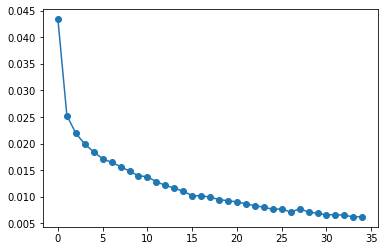

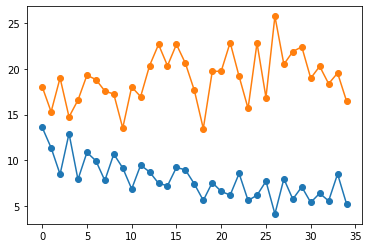

In [5]:
"""Plotting Results"""

# print("Checking final accuracy on training data.")
# check_accuracy(train_loader, model)

# print("Checking final accuracy on testing data.")
# check_accuracy(test_loader, model)



def plot(loss, train_acc, test_acc):
    plt.figure()
    plt.scatter(range(0, len(all_losses)), loss)
    plt.plot(range(0, len(all_losses)), loss)
    
    plt.figure()
    plt.scatter(range(0, len(train_acc)), train_acc)
    plt.scatter(range(0, len(test_acc)), test_acc)
    plt.plot(range(0, len(train_acc)), train_acc)
    plt.plot(range(0, len(test_acc)), test_acc)
    
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d,%m,%Y_%H,%M,%S")
#     plt.savefig('../plots/loss_accuracy_' + dt_string + '.png')

print(all_losses)
plot(all_losses, all_train_acc, all_test_acc)

In [6]:
"""Getting prediction on single custom image"""
IMG_FILE = "../test_face2.jpg"

test_img = torch.Tensor(cv2.cvtColor(cv2.imread(IMG_FILE), cv2.COLOR_BGR2GRAY))   #getting image with shape (48, 48)
test_img = test_img.unsqueeze(0).unsqueeze(0)  #adding 2 dimensions to the image to get it to shape (1, 1, 48, 48). The 1st dimension represents batch of 1, the second represents color channels (I think)
outputs = model(test_img)
print(outputs)

tensor([[0.8682]], grad_fn=<AddmmBackward>)


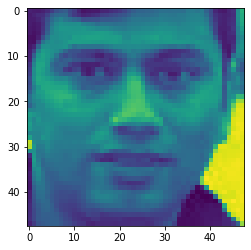

prediction: 29.162731.      Label: 28.000000


In [23]:
"""Getting prediction on a random image from the dataset (and retreiving label)"""
import random
item_tuple = dataset.__getitem__(random.randint(0, dataset.__len__()-1))
image = item_tuple[0]
label = item_tuple[1]*100

%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()

image = torch.Tensor(image)
image = image.unsqueeze(0).unsqueeze(0)  #adding 2 dimensions to the image to get it to shape (1, 1, 48, 48). The 1st dimension represents batch of 1, the second represents color channels (I think)
outputs = model(image) * 100
print("prediction: %f.      Label: %f" % (outputs, label))

In [8]:
# """Getting prediction on a random image from the dataset (and retreiving label)"""
# import random
# item_tuple = dataset.__getitem__(random.randint(0, dataset.__len__()-1))
# image = item_tuple[0]
# label = item_tuple[1]

# %matplotlib inline
# from matplotlib import pyplot as plt
# plt.imshow(image)
# plt.show()

# __, img = torch.utils.data.random_split(dataset, [num_data_items-1, 1])
# loader = DataLoader(dataset=img, batch_size=1, shuffle=True)
# for batch_idx, (data, targets) in enumerate(loader):   #Looping through batches
#     #Get data to cuda if possible
#     data = data.to(device=device)             #data is a torch tensor of [batch size] 48x48 images (shape=[batch size,48,48])
#     data = data.unsqueeze(1)                  #Add a dimension to the tensor for number of channels (which is 1)

#     #Forward prop
#     scores = model(data.float()).reshape(-1)

#     print("prediction: %f.      Label: %d" % (scores.item(), int(label.item())))